# Imports and File Processing

---



In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tkinter import filedialog, Tk
import os
from scipy.constants import e, h
import ipywidgets as widgets
from IPython.display import display
import io

In [2]:
def load_data(file_path, encoding='latin1'):
    with open(file_path, 'r', encoding=encoding) as file:
        lines = file.readlines()

    metadata = {}
    data_start_line = None
    for i, line in enumerate(lines):
        if line.strip() == '---------':
            data_start_line = i + 2
            break
        key_value = line.split(':', 1)
        if len(key_value) == 2:
            key, value = key_value
            metadata[key.strip()] = value.strip()

    if data_start_line is None:
        raise ValueError("Data start line not found")

    step_value = None
    for line in lines:
        if "Step value:" in line:
            step_value = line.split(":")[1].strip()
            break
    metadata["Step value"] = step_value

    data_lines = lines[data_start_line:]
    data = []
    for line in data_lines:
        split_line = line.strip().split('\t')
        if len(split_line) == 8:
            try:
                data.append([float(val) for val in split_line])
            except ValueError:
                continue

    if len(data) == 0:
        raise ValueError("No valid data found")

    df = pd.DataFrame(data, columns=['B', 'Keysight2', 'Agilent_Ch1', 'Keysight1_Ch1', 'Keysight3', 'Rxx', 'irrel', 'extra'])
    return df, metadata

In [3]:
def plot_conductivity(data, Vg, output_dir):
    B = data['B']
    G = 1 / data['Rxx']
    G = G / (e**2 / h)

    plt.figure()
    plt.plot(B, G, label=f'Conductivity G (Vg={Vg} V)')
    plt.xlabel('Magnetic Field B [T]')
    plt.ylabel('Conductivity G [$e^2/h$]')
    plt.title(f'Conductivity vs Magnetic Field (Vg={Vg} V)')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'conductivity_Vg_{Vg}.png'))
    plt.close()

In [4]:
def calculate_g_diff(B, G, window_size=100):
    window_size = min(window_size, len(G) // 2 * 2 + 1)
    if window_size < 5:
        window_size = 5

    G_smooth = savgol_filter(G, window_size, 4)
    G_diff = G - G_smooth

    return B, G_diff

In [5]:
def plot_g_diff_intervals(B, G_diff, Vg, output_dir, start=-0.1, interval_size=1.2, overlap=0.1):
    max_B = min(max(B), 8)
    while start < max_B:
        end = start + interval_size
        if end > 8:
            end = 8
        mask = (B >= start) & (B < end)
        B_interval = B[mask]
        G_diff_interval = G_diff[mask]

        plt.figure()
        plt.plot(B_interval, G_diff_interval, label=f'$V_g$ = {Vg} V')
        plt.xlabel('B [T]')
        plt.ylabel('$G_{diff}$ [$e^2/h$]')
        plt.title(f'$G_{{diff}}$ vs B from {start:.1f}T to {end:.1f}T')
        plt.legend(loc='upper right')
        plt.xlim([start, end])
        plt.savefig(os.path.join(output_dir, f'Gdiff_{start:.1f}T_to_{end:.1f}T_Vg_{Vg}.png'))
        plt.close()

        start = start + interval_size - overlap


In [6]:
def plot_all_g_diff(g_diff_data, output_path):
    plt.figure(figsize=(12, 8))
    offset = 0
    for Vg, (B, G_diff) in g_diff_data.items():
        plt.plot(B, G_diff + offset, label=f'$V_g$ = {Vg} V')
        offset += 0.2
    plt.xlabel('B [T]')
    plt.ylabel('$G_{diff}$ [$e^2/h$]')
    plt.xlim(0, 8)
    plt.ylim(-0.2, offset)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

In [7]:
def plot_all_g_diff_centered(g_diff_data, output_path):
    plt.figure(figsize=(12, 8))
    offset = 0
    for Vg, (B, G_diff) in g_diff_data.items():
        mask = (B >= -0.5) & (B <= 0.5)
        B_centered = B[mask]
        G_diff_centered = G_diff[mask]
        plt.plot(B_centered, G_diff_centered + offset, label=f'$V_g$ = {Vg} V')
        offset += 0.2
    plt.xlabel('B [T]')
    plt.ylabel('$G_{diff}$ [$e^2/h$]')
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.2, offset)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

In [8]:
def plot_g_vs_vg_at_b0(g_data, output_path):
    Vg_values = []
    G_values = []
    for Vg, (B, G) in g_data.items():
        idx = (np.abs(B)).argmin()
        G_at_b0 = G[idx]
        Vg_values.append(float(Vg))
        G_values.append(G_at_b0)

    sorted_indices = np.argsort(Vg_values)
    Vg_sorted = np.array(Vg_values)[sorted_indices]
    G_sorted = np.array(G_values)[sorted_indices]

    plt.figure(figsize=(8, 6))
    plt.plot(Vg_sorted, G_sorted, color='black')
    plt.xlabel('$V_g$ [V]')
    plt.ylabel('$G$ [$e^2/h$]')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

In [9]:
def plot_g_diff_vs_vg_at_b0(g_diff_data, output_path):
    Vg_values = []
    G_diff_values = []
    for Vg, (B, G_diff) in g_diff_data.items():
        idx = (np.abs(B)).argmin()
        G_diff_at_b0 = G_diff[idx]
        Vg_values.append(float(Vg))
        G_diff_values.append(G_diff_at_b0)

    sorted_indices = np.argsort(Vg_values)
    Vg_sorted = np.array(Vg_values)[sorted_indices]
    G_diff_sorted = np.array(G_diff_values)[sorted_indices]

    plt.figure(figsize=(8, 6))
    plt.plot(Vg_sorted, G_diff_sorted, color='black')
    plt.xlabel('$V_g$ [V]')
    plt.ylabel('$G_{diff}$ [$e^2/h$]')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


# Process Block

---

In [10]:
def process_and_plot_all_g_diff(input_dir, output_dir):
    g_diff_data = {}
    g_data = {}

    # Create output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)

    # Process all .dat files in the input directory
    for file_path in glob.glob(os.path.join(input_dir, '*.dat')):
        data, metadata = load_data(file_path)
        Vg = metadata.get("Step value", "unknown")
        output_subdir = os.path.join(output_dir, f'Vg_{Vg}')
        os.makedirs(output_subdir, exist_ok=True)

        B = data['B']
        G = 1 / data['Rxx'] / (e**2 / h)
        B, G_diff = calculate_g_diff(B, G)

        g_diff_data[Vg] = (B, G_diff)
        g_data[Vg] = (B, G)
        plot_conductivity(data, Vg, output_subdir)
        plot_g_diff_intervals(B, G_diff, Vg, output_subdir)

    plot_all_g_diff(g_diff_data, os.path.join(output_dir, 'all_g_diff.png'))
    plot_all_g_diff_centered(g_diff_data, os.path.join(output_dir, 'all_g_diff_centered.png'))
    plot_g_vs_vg_at_b0(g_data, os.path.join(output_dir, 'g_vs_vg_at_b0.png'))
    plot_g_diff_vs_vg_at_b0(g_diff_data, os.path.join(output_dir, 'g_diff_vs_vg_at_b0.png'))





# **Main**

---

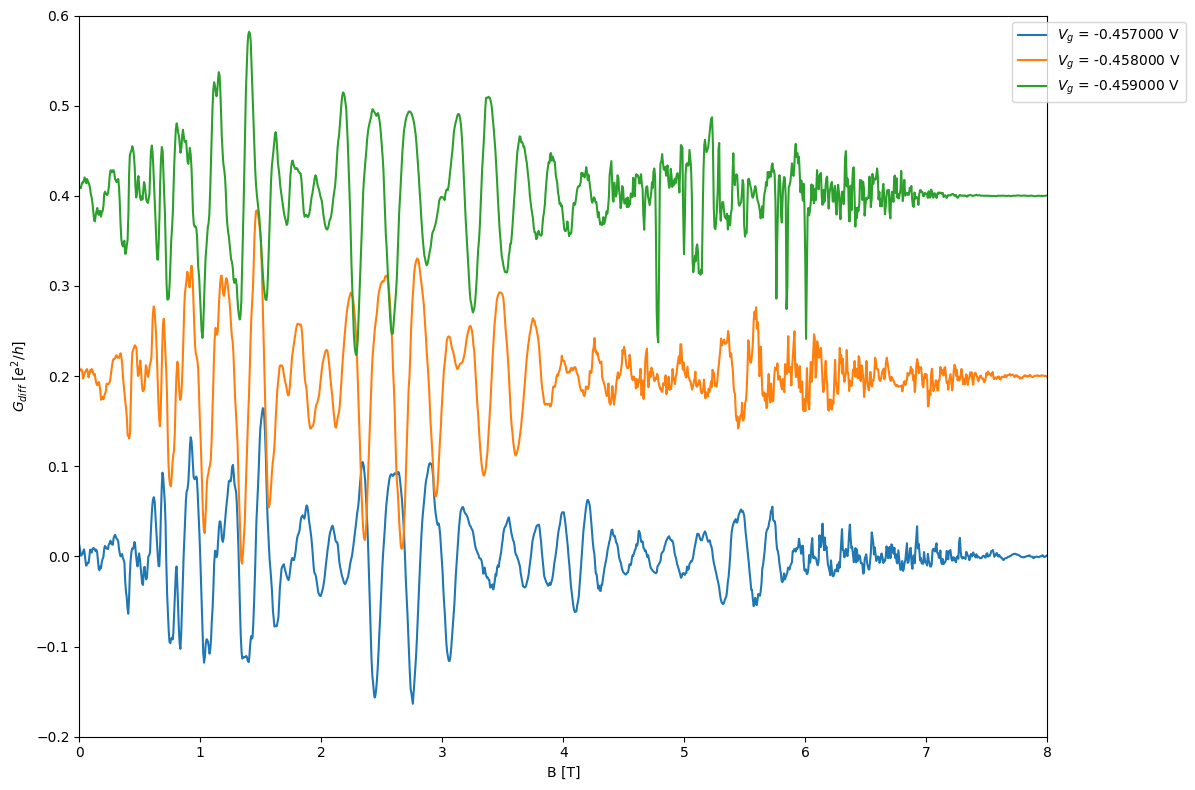

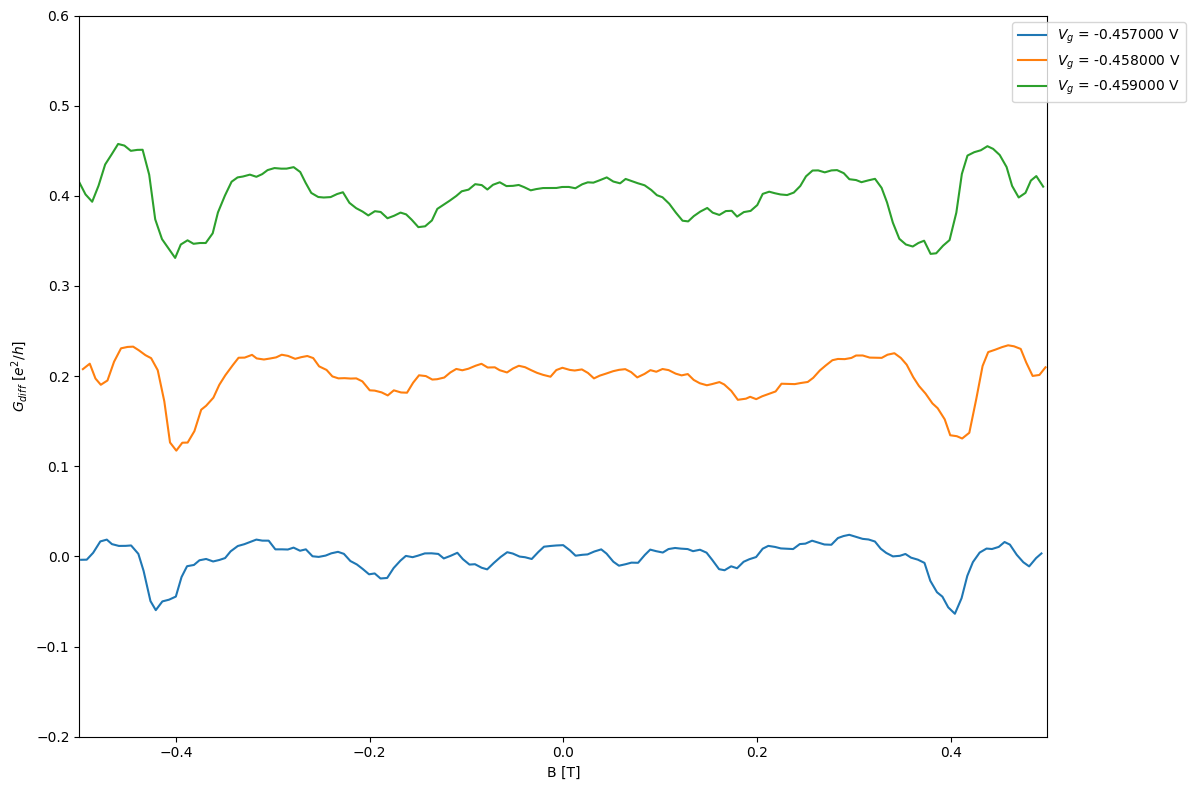

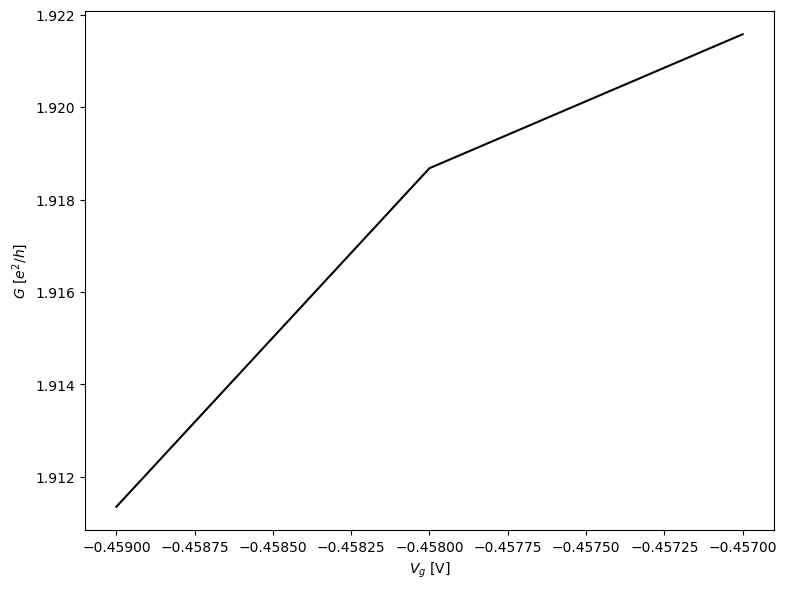

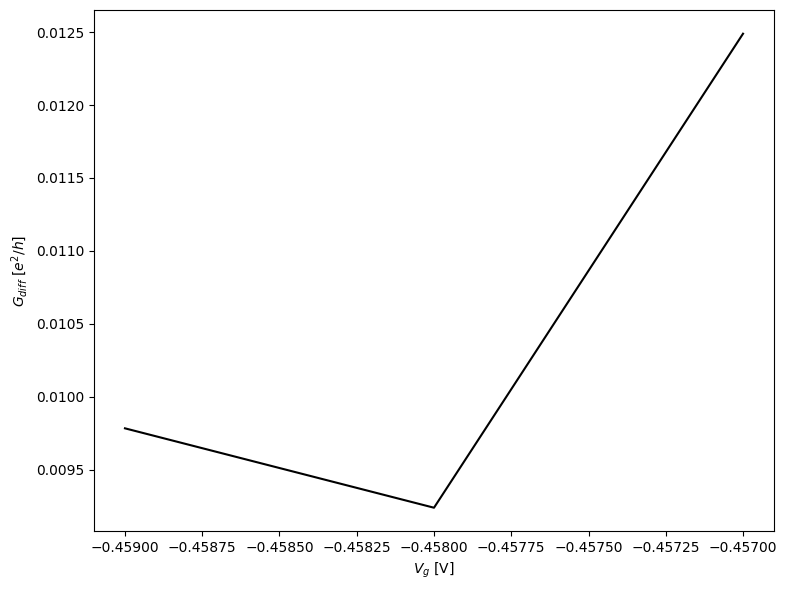

In [11]:
if __name__ == "__main__":
    input_directory = r'C:\Users\amrsh\Downloads\data'
    output_directory = r'C:\Users\amrsh\Downloads\Output'
    process_and_plot_all_g_diff(input_directory, output_directory)